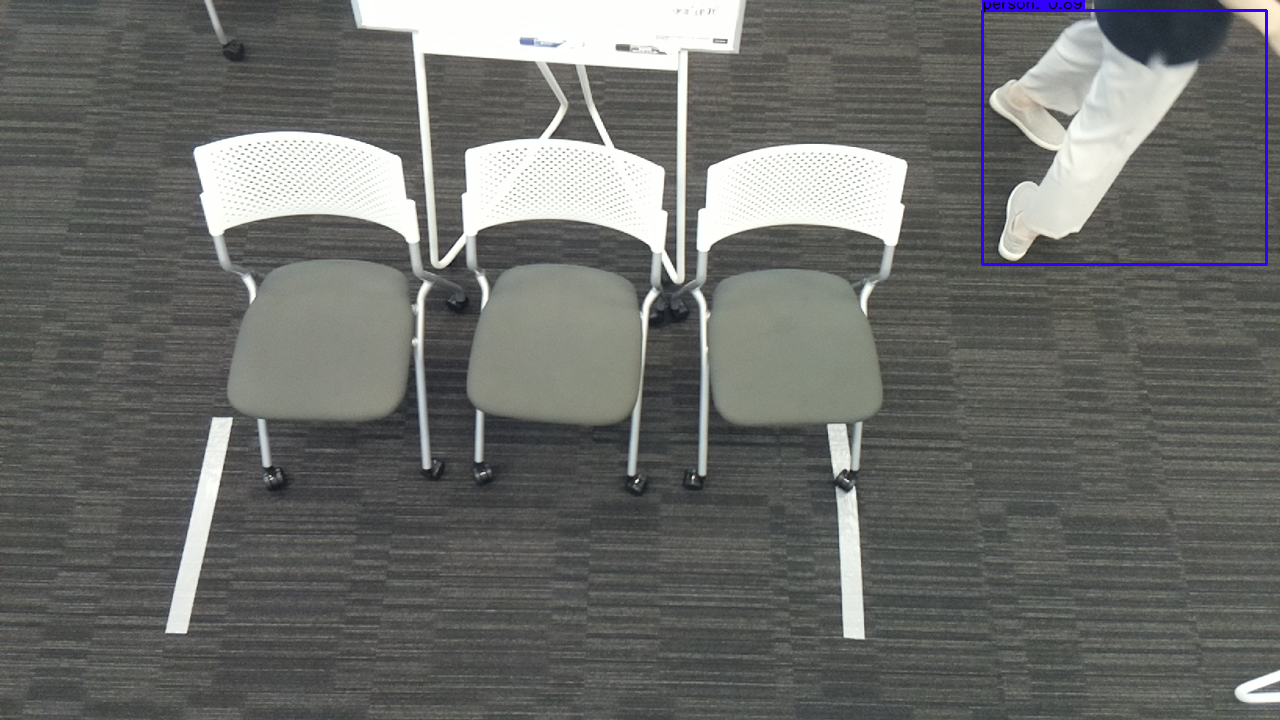

In [2]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from IPython.display import display

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
image_path      = "./images/test1563948103.2233362.jpg"
num_classes     = 80
input_size      = 416
graph           = tf.Graph()

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...]

return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)


with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run(
        [return_tensors[1], return_tensors[2], return_tensors[3]],
                feed_dict={ return_tensors[0]: image_data})

pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)

bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
bboxes = utils.nms(bboxes, 0.4, method='nms')
image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)
# image.show()
display(image)

In [13]:
for box in bboxes:
    print(box[1])

5.220407485961914
14.768301963806152
71.02665710449219


In [3]:
bboxes

[array([9.82175171e+02, 1.06565981e+01, 1.26644238e+03, 2.64613098e+02,
        8.86111200e-01, 0.00000000e+00])]

In [3]:
bboxes[0]

array([399.01287842, 219.5496521 , 574.82592773, 471.54928589,
         0.9978981 ,   0.        ])

In [4]:
bboxes[1]

array([402.72622681,  11.59717941, 526.85723877, 186.44424438,
         0.6120711 ,   0.        ])

In [9]:
# ai 서버, display 클라이언트
# server.py

import flask
from flask import request, make_response, jsonify
from PIL import Image
import time

import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from IPython.display import display

import requests

num_seats = input("좌석 수 :")
num_seats = int(num_seats)
global empty_num_seats
empty_num_seats = num_seats

app = flask.Flask(__name__)

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
image_path      = "./images/capture.jpg"
num_classes     = 80
input_size      = 128
graph           = tf.Graph()

# IP = "172.29.148.144"
# PORT = 8899


@app.route('/api/calculateEmptySeats', methods=['POST'])
def match():
    image = request.files['file']
    if image:
        image_path = 'images/test{}.jpg'.format(time.time())
        with open(image_path, 'wb') as fw:
            fw.write(image.read())
            
            start = time.time()
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            original_image_size = original_image.shape[:2]
            image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
            image_data = image_data[np.newaxis, ...]
            
            pred_sbbox, pred_mbbox, pred_lbbox = sess.run([return_tensors[1], return_tensors[2], return_tensors[3]],feed_dict={ return_tensors[0]: image_data})
            pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),np.reshape(pred_mbbox, (-1, 5 + num_classes)),np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)
            
            bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.1)
            bboxes = utils.nms(bboxes, 0.5, method='nms')
            image = utils.draw_bbox(original_image, bboxes)
            image = Image.fromarray(image)
            print("Number of total seats: {}".format(num_seats))
            num_people = 0
            for box in bboxes:
                if box[5] == 0.0:
                    print("width: {}, y1: {}, x1: {}, x2: {}, y2: {}".format(box[2]-box[0],box[1],box[0], box[2], box[3]))
                if box[5] == 0.0 and box[2]-box[0] < 400.0 and box[1] < 300 and box[0] < 900 and box[2] > 300 and box[3] > 300:
                    num_people += 1
            print("Number of people: {}".format(num_people))
            global empty_num_seats
            empty_num_seats = num_seats-num_people
            if empty_num_seats < 0:
                empty_num_seats = 0
            print("Number of empty seats: {}".format(empty_num_seats))
#             requests.post(url="http://{}:{}/api/displayEmptySeats".format(IP,PORT), data={"num_empty_seats": num_seats})
            
            image.show()
            # display(image)
            end = time.time()
            print("{}seconds".format(end-start))
    else:
        print('Image empty!')
    return 'OK'

@app.route("/api/displayEmptySeats", methods=["POST"])
def display():
    global empty_num_seats
    
#     if empty_num_seats < 9:
#         empty_num_seats += 1
#     else:
#         empty_num_seats = 0
    return make_response(jsonify({"num_empty_seats": empty_num_seats}))

return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)
with tf.Session(graph=graph) as sess:
    app.run('0.0.0.0', port=5001, threaded=True)


좌석 수 :3
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
26.39745306968689seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
2.4048798084259033seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
2.376553535461426seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
4.386031627655029seconds
Number of total seats: 3
width: 253.75408935546875, y1: 147.2082061767578, x1: 971.9153442382812, x2: 1225.66943359375, y2: 385.39215087890625
Number of people: 0
Number of empty seats: 3
3.3112707138061523seconds
Number of total seats: 3
width: 258.0633544921875, y1: 146.81625366210938, x1: 972.7725830078125, x2: 1230.8359375, y2: 382.0033264160156
Number of people: 0
Number of empty seats: 3
2.4691336154937744seconds
Number of total seats: 3
width: 202.0830078125, y1: 91

In [7]:
# # display 서버

# import flask
# from flask import request, make_response, jsonify
# import time

# app = flask.Flask(__name__)

# @app.route("/api/displayEmptySeats", methods=["POST"])
# def match():
#     num_empty_seats = int(request.values["num_empty_seats"])
#     print("빈 좌석 수: {}".format(num_empty_seats))
    
#     return make_response(jsonify({"num_empty_seats": 4}))

# app.run("0.0.0.0", port=8899, threaded=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [59]:
# 빈 좌석 수 요청
# response.py


import requests

IP = "172.29.148.137"
PORT = 5001

res = requests.post(url="http://{}:{}/api/displayEmptySeats".format(IP,PORT))
res = res.text
res = res.split(':')[1]
res = res.split('}')[0]
res = int(res)
print(res)

4


In [ ]:
# 카메라로 찍은 사진 server에 전달
# client.py

from picamera import PiCamera
import time
from PIL import Image
import socket
import base64
import requests
from io import BytesIO

IP = '172.29.148.137'
PORT = 5001
#IMAGE_SIZE = (1920, 1080)
#IMAGE_SIZE = (1366, 768)
#time.sleep(5)

#with PiCamera(resolution=IMAGE_SIZE) as camera:
with PiCamera() as camera:
        stream = BytesIO()
        for i in camera.capture_continuous(stream, format='jpeg', use_video_port = True):
                stream.truncate()
                stream.seek(0)
                barray = stream.read(stream.getbuffer().nbytes)
                requests.post('http://{}:{}/api/calculateEmptySeats'.format(IP, PORT), files={'file': barray})
                time.sleep(10)
                stream.seek(0)